In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_forecast_component
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_error

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.0f}'.format)

In [2]:
# importing the data

sales_data = pd.read_csv('cleaned_sales_data.csv')
prod_prices = pd.read_csv('Producer_Prices.csv')
mat_prices = pd.read_csv('Prices_of_Materials.csv')
prod_index = pd.read_csv('Production_Index.csv')
prod_ship = pd.read_csv('Production_Shipments.csv')

In [3]:
# Merging the market data using the date

market_data = pd.merge(prod_prices, mat_prices, on='date', how='outer')
market_data = pd.merge(market_data, prod_index, on='date', how='outer')
market_data = pd.merge(market_data, prod_ship, on='date', how='outer')

In [4]:
market_data.tail()

,date,PRI27840_org,PRI27826_org,PRI27380_org,PRI27250_org,PRI27276_org,PRI27156_org,RohiBASEMET1000_org,RohiENERGY1000_org,RohiMETMIN1000_org,RohiNATGAS1000_org,RohCRUDE_PETRO1000_org,RohCOPPER1000_org,WKLWEUR840_org,PRO28840_org,PRO281000_org,PRO28756_org,PRO28826_org,PRO28380_org,PRO28392_org,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_PRO840,MAB_ELE_SHP840,MAB_ELE_PRO1100,MAB_ELE_SHP1100
214,2021-12-01,129,NaN,113,108,116,98,125,112,117,236,92,127,1,106,135,102,90,103,137,113,129,110,132,114,121,73,109,81,98,311,311,101,135,118,149,94,150,128,131,107,105,101,NaN,107,149,123,150
215,2022-01-01,132,NaN,115,111,118,98,133,121,125,197,106,130,1,111,117,100,85,92,118,91,92,111,122,109,112,74,95,78,99,236,236,86,108,95,120,87,101,110,111,103,102,95,NaN,111,130,103,120
216,2022-02-01,133,NaN,116,112,119,99,139,131,131,198,118,132,1,117,125,98,89,113,125,98,103,115,127,104,116,91,104,79,106,236,236,91,118,104,129,107,121,118,118,100,99,98,NaN,116,139,114,132
217,2022-03-01,136,NaN,117,112,120,99,150,163,141,271,142,136,1,119,149,96,109,134,161,115,122,115,152,98,145,102,134,97,120,329,329,108,137,121,151,125,154,152,156,97,95,122,NaN,118,166,133,158
218,2022-04-01,138,NaN,118,113,121,99,146,153,138,243,131,135,1,119,128,NaN,85,111,120,92,99,112,135,NaN,114,86,102,81,101,267,267,88,117,100,127,104,129,114,115,NaN,NaN,95,NaN,117,NaN,113,135


In [5]:
sales_data.sample(5)

,Mapped_GCK,Sales_EUR,date
4871,#12,0,2021-07-20
5142,#1,0,2021-02-22
4643,#5,0,2018-12-22
6231,#8,0,2020-03-04
4581,#6,0,2020-09-14


In [6]:
sales_data.dtypes

Mapped_GCK     object
Sales_EUR     float64
date           object
dtype: object

In [7]:
sales_data['date'] = pd.to_datetime(sales_data['date'])

sales_data['YearMonth'] = sales_data['date'].dt.to_period('M')

# Step 2: Aggregate total revenue per product per month
monthly_revenue = sales_data.groupby(['Mapped_GCK', 'YearMonth'])['Sales_EUR'].sum().reset_index()

# Step 3: Convert 'YearMonth' to the first day of the month ('YYYY-MM-01')
monthly_revenue['date'] = monthly_revenue['YearMonth'].dt.to_timestamp()

# Drop 'YearMonth' if it's no longer needed
sales_data = monthly_revenue.drop(columns=['YearMonth'])

In [8]:
sales_data.shape

(602, 3)

In [9]:
sales_data.sample(5)

,Mapped_GCK,Sales_EUR,date
466,#5,11472426,2021-10-01
505,#6,493449,2021-06-01
127,#12,418372,2022-03-01
369,#36,4127,2020-11-01
485,#6,581768,2019-10-01


# Feature Selection

In [10]:
# Ensure 'Date_my' is in datetime format for both datasets
market_data['date'] = pd.to_datetime(market_data['date'])

# Merge sales data with market index data on 
df = sales_data.merge(market_data, on='date', how='left')

# Extract time-based features
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month

# Dictionary to store top features per product
top_features_dict = {}

In [11]:
df['Mapped_GCK'].unique()

array(['#1', '#11', '#12', '#13', '#14', '#16', '#20', '#3', '#36', '#4',
       '#5', '#6', '#8', '#9'], dtype=object)

In [12]:
# Define features and target
X = df.drop(columns=['date','Mapped_GCK' ,'Sales_EUR' , 'Year' , 'Month'])
y = df['Sales_EUR']
    
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    
# Train XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric="rmse", n_estimators=100, random_state=42)
model.fit(X_train, y_train)
    
# Get feature importances
feature_importance = model.feature_importances_
feature_names = X.columns


<Figure size 1000x600 with 0 Axes>

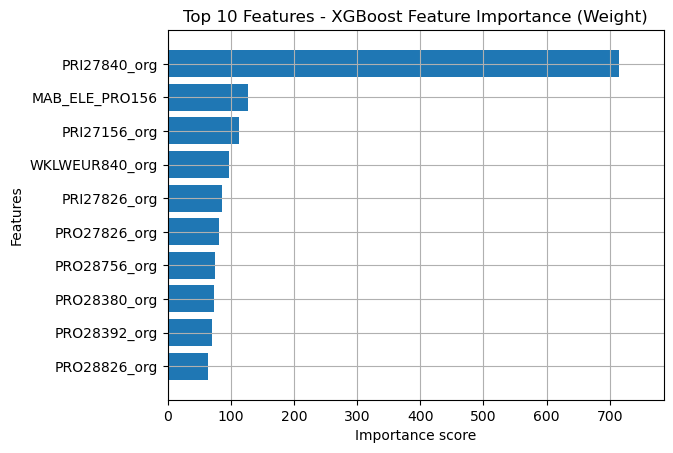

In [13]:
plt.figure(figsize=(10, 6))
plot_importance(model, importance_type="weight", show_values=False, height=0.8, max_num_features=10)
plt.title("Top 10 Features - XGBoost Feature Importance (Weight)")
plt.show()

According to the number of time the feature is used to split the data we should keep 'PRI27840_org'

<Figure size 1000x600 with 0 Axes>

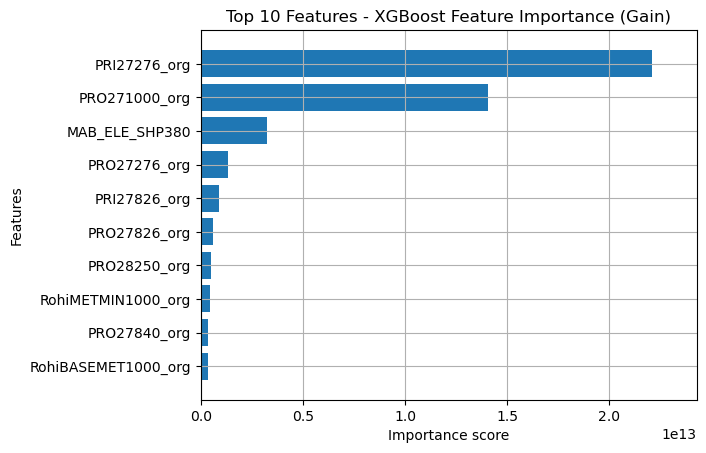

In [14]:
# Filter the model to show only the top 10 features
plt.figure(figsize=(10, 6))
plot_importance(model, importance_type="gain", show_values=False, height=0.8, max_num_features=10)
plt.title("Top 10 Features - XGBoost Feature Importance (Gain)")
plt.show()

According to this the feature that helps the most with training loss reduction is 'PRI27276_org' and 'PRO271000_org'. We should keep this feature

<Figure size 1000x600 with 0 Axes>

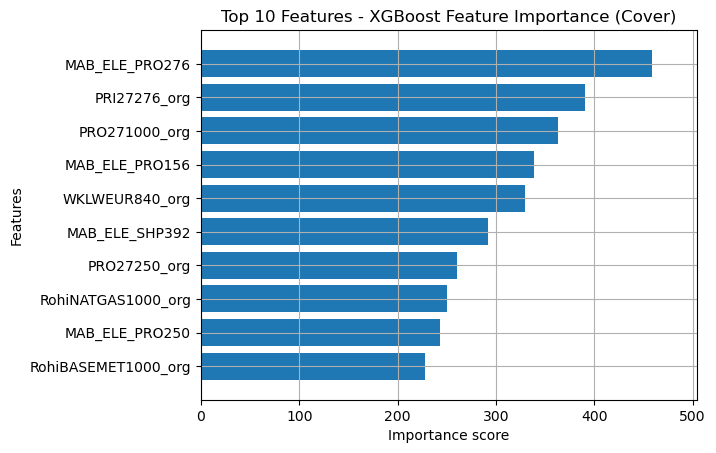

In [15]:
# Filter the model to show only the top 10 features
plt.figure(figsize=(10, 6))
plot_importance(model, importance_type="cover", show_values=False, height=0.8, max_num_features=10)
plt.title("Top 10 Features - XGBoost Feature Importance (Cover)")
plt.show()

To the cover we set an treshold of 300 to filter the features and we should keep the following features:
- MAB_ELE_PRO276
- PRI27276_org  
- PRO271000_org 
- WKLWEUR840_org 
- MAB_ELE_PRO156 

In [16]:
# Let's store the features, notice that Mapped_GCK and date are mandatory features for the model

features_model = ['MAB_ELE_PRO276',
  'PRI27276_org',  
  'PRO271000_org', 
  'WKLWEUR840_org', 
  'MAB_ELE_PRO156',
  'PRI27840_org']

features = ['MAB_ELE_PRO276',
  'PRI27276_org',  
  'PRO271000_org', 
  'WKLWEUR840_org', 
  'MAB_ELE_PRO156',
  'PRI27840_org',  
  'Mapped_GCK',
  'date', 
  'Sales_EUR']
    

In [17]:
# Filtering the features
df_model = df.copy()
df_model = df_model[features]



# Encoding

In [18]:
encoder = LabelEncoder()

# Fit and transform the data
encoded_data = encoder.fit_transform(df_model['Mapped_GCK'])

df_model['Mapped_GCK'] = encoded_data


In [19]:
df_model['ds'] = df_model['date']
df_model['y'] = df_model['Sales_EUR']

# Splitting the data with the date criteria. being train with dates before 04-2021 and test with dates after 04-2021
X_train = df_model[df_model['date'] < '2021-05-01']
X_test = df_model[df_model['date'] >= '2021-05-01']

# Models

In [20]:
rmse_results = {}

## Prophet

Prophet without features

In [22]:
model_name = 'Prophet_vanila'

plt.figure(figsize=(12, 6))  # Create a single figure

for product in X_train['Mapped_GCK'].unique():
    # Filter data for the current product
    train_data = X_train[X_train['Mapped_GCK'] == product].copy()
    test_data = X_test[X_test['Mapped_GCK'] == product].copy()

    # Define logistic growth limits
    train_data['floor'] = 0
    train_data['cap'] = train_data['y'].max() * 1.5
    
    # Initialize Prophet model with logistic growth
    model = Prophet(growth='logistic')

    # Fit the model
    model.fit(train_data)

    # Create future dataframe
    future = model.make_future_dataframe(periods=18, freq='MS')
    #future = future[future['ds'] > '2021-03-01']  # Ensure only future predictions
    future['floor'] = 0
    future['cap'] = train_data['y'].max() * 1.5

    # Predict sales
    forecast = model.predict(future)

    # Compute RMSE
    rmse = root_mean_squared_error(test_data['y'], forecast['yhat'])
    
    # Store RMSE in dictionary
    if product not in rmse_results:
        rmse_results[product] = {}
    rmse_results[product][model_name] = rmse  

    # Plot predicted values (with unique color per product)
    plt.plot(forecast['ds'], forecast['yhat'], linestyle='-', marker='x', label=f'Predicted - {product}')

    # Plot actual values (scatter plot for better visibility)
    plt.scatter(test_data['ds'], test_data['y'], alpha=0.6, marker='o', label=f'Actual - {product}')

# Finalize the global plot
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Forecast vs Actual Sales for Multiple Products')
plt.legend()
plt.show()

# Convert RMSE dictionary to DataFrame
rmse_df = pd.DataFrame.from_dict(rmse_results, orient='index')

23:57:09 - cmdstanpy - INFO - Chain [1] start processing
23:57:09 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Found input variables with inconsistent numbers of samples: [12, 49]

<Figure size 1200x600 with 0 Axes>

Prophet with features

23:46:45 - cmdstanpy - INFO - Chain [1] start processing
23:46:46 - cmdstanpy - INFO - Chain [1] done processing
23:46:46 - cmdstanpy - INFO - Chain [1] start processing
23:46:46 - cmdstanpy - INFO - Chain [1] done processing
23:46:47 - cmdstanpy - INFO - Chain [1] start processing
23:46:47 - cmdstanpy - INFO - Chain [1] done processing
23:46:47 - cmdstanpy - INFO - Chain [1] start processing
23:46:48 - cmdstanpy - INFO - Chain [1] done processing
23:46:48 - cmdstanpy - INFO - Chain [1] start processing
23:46:49 - cmdstanpy - INFO - Chain [1] done processing
23:46:49 - cmdstanpy - INFO - Chain [1] start processing
23:46:49 - cmdstanpy - INFO - Chain [1] done processing
23:46:49 - cmdstanpy - INFO - Chain [1] start processing
23:46:50 - cmdstanpy - INFO - Chain [1] done processing
23:46:50 - cmdstanpy - INFO - Chain [1] start processing
23:46:50 - cmdstanpy - INFO - Chain [1] done processing
23:46:51 - cmdstanpy - INFO - Chain [1] start processing
23:46:51 - cmdstanpy - INFO - Chain [1]

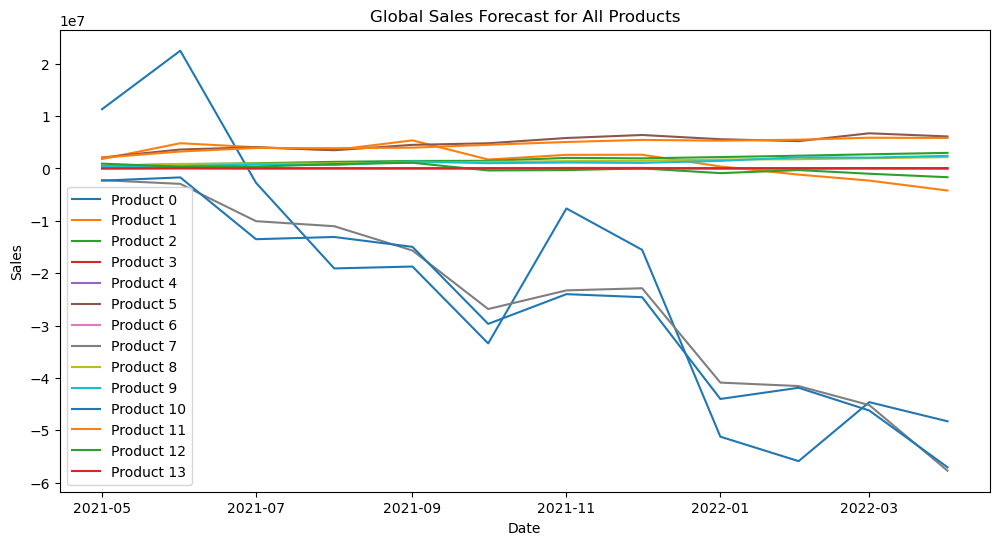

In [ ]:
forecasts = {}

plt.figure(figsize=(12, 6))  # Create a single figure

# Loop over each unique product ID
for product in X_train['Mapped_GCK'].unique():

    train_data = X_train[X_train['Mapped_GCK'] == product]
    test_data = X_test[X_test['Mapped_GCK'] == product]
    train_data['floor'] = 0
    train_data['cap'] = train_data['y'].max() * 1.5

    # Initialize Prophet model
    model = Prophet(growth='logistic')
    
    # Add each feature as a regressor
    for feature in features_model:
        model.add_regressor(feature)

    # Fit the model on training data
    model.fit(train_data)

    # Create future dataframe using test data
    future = test_data[['ds']].copy()
    for feature in features_model:
        future[feature] = test_data[feature].values  # Ensure alignment
        future['floor'] = 0
        future['cap'] = train_data['y'].max() * 1.5

    # Predict sales
    forecast = model.predict(future)
    forecasts[product] = forecast  # Store results

    # Plot each product's forecast on the same figure
    plt.plot(forecast['ds'], forecast['yhat'], label=f'Product {product}')

# Finalize the global plot
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Global Sales Forecast for All Products')
plt.legend()  # Show product labels
plt.show()

23:42:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 0


23:42:42 - cmdstanpy - INFO - Chain [1] done processing


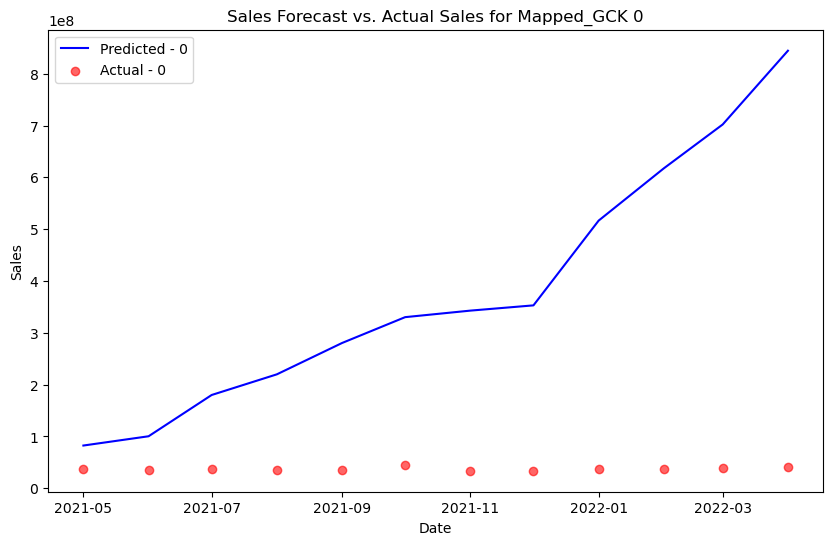

23:42:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 1


23:42:43 - cmdstanpy - INFO - Chain [1] done processing


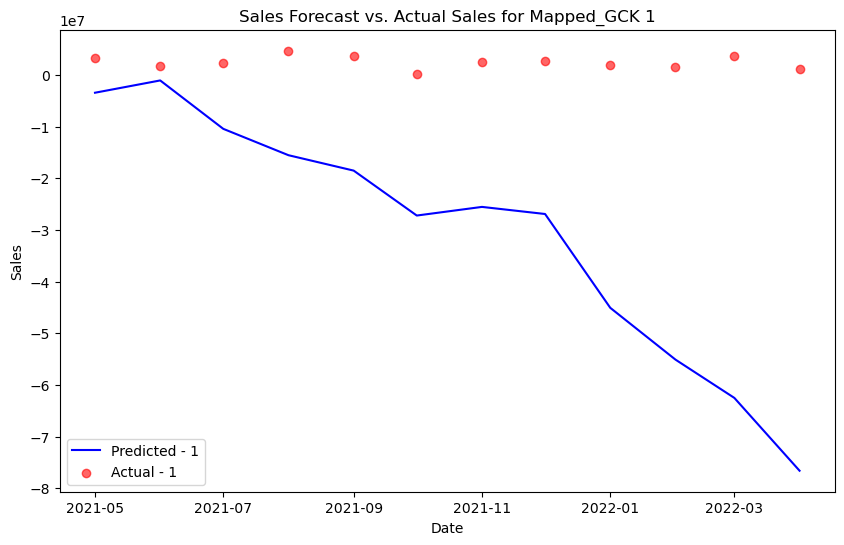

23:42:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 2


23:42:43 - cmdstanpy - INFO - Chain [1] done processing


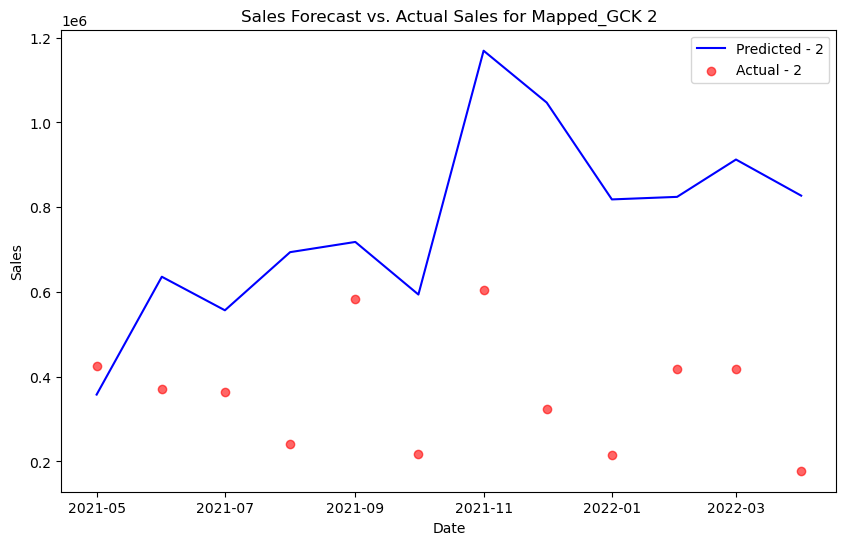

23:42:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 3


23:42:44 - cmdstanpy - INFO - Chain [1] done processing


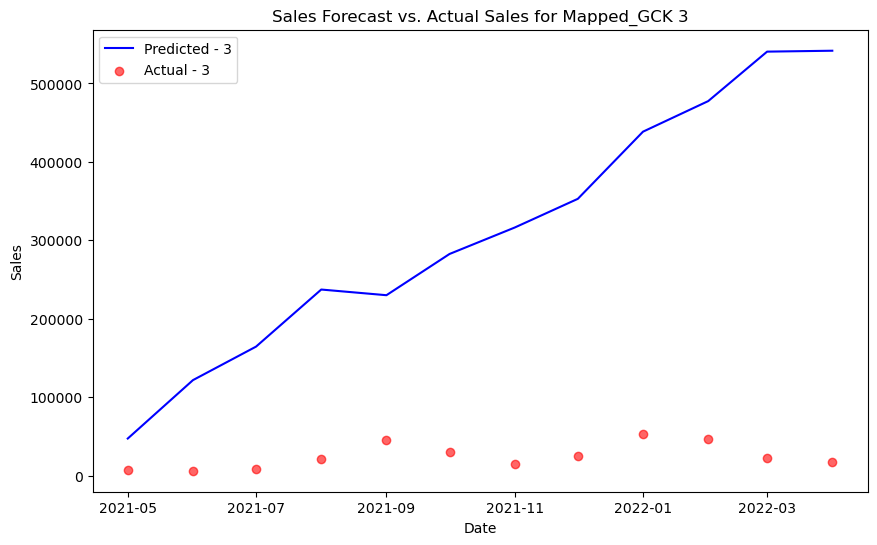

23:42:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 4


23:42:45 - cmdstanpy - INFO - Chain [1] done processing


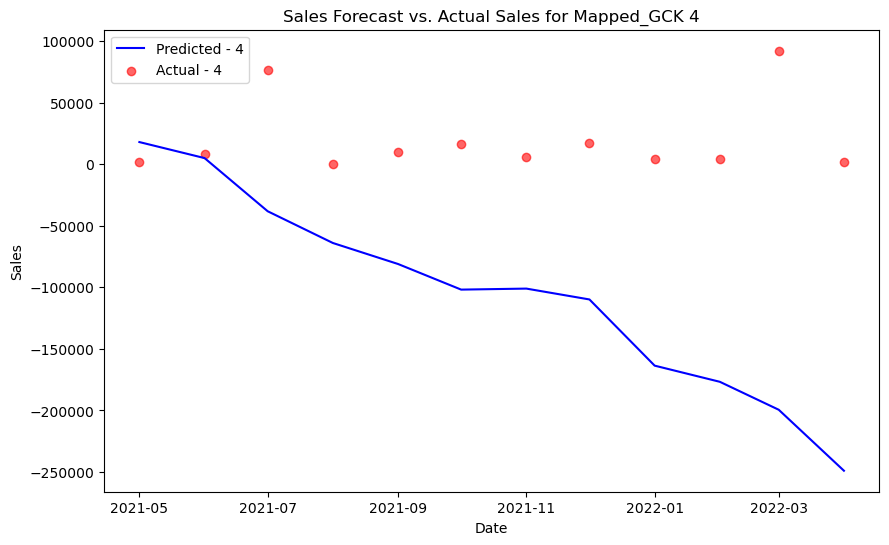

23:42:45 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 5


23:42:45 - cmdstanpy - INFO - Chain [1] done processing


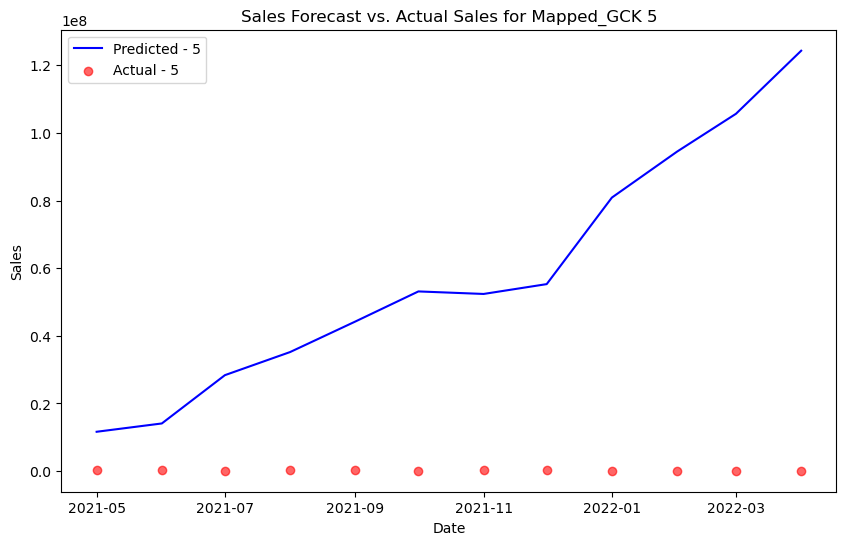

23:42:46 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 6


23:42:46 - cmdstanpy - INFO - Chain [1] done processing


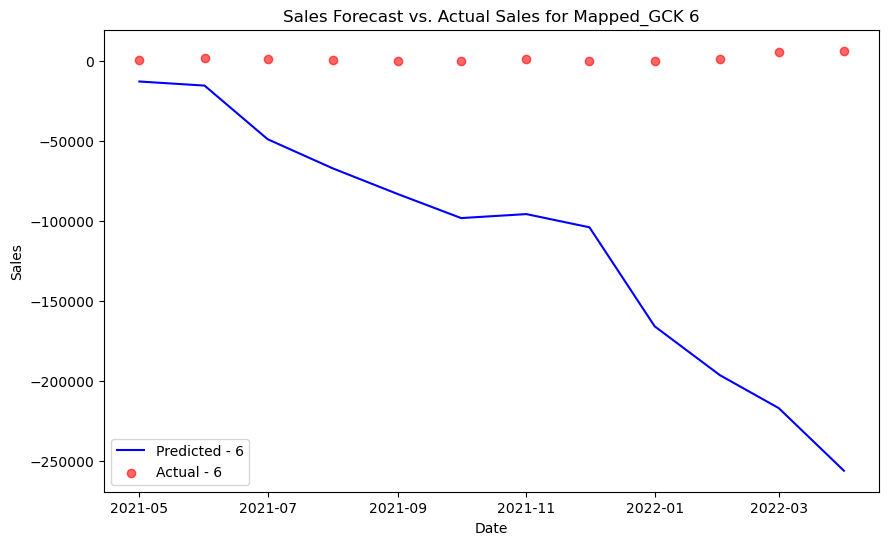

23:42:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 7


23:42:47 - cmdstanpy - INFO - Chain [1] done processing


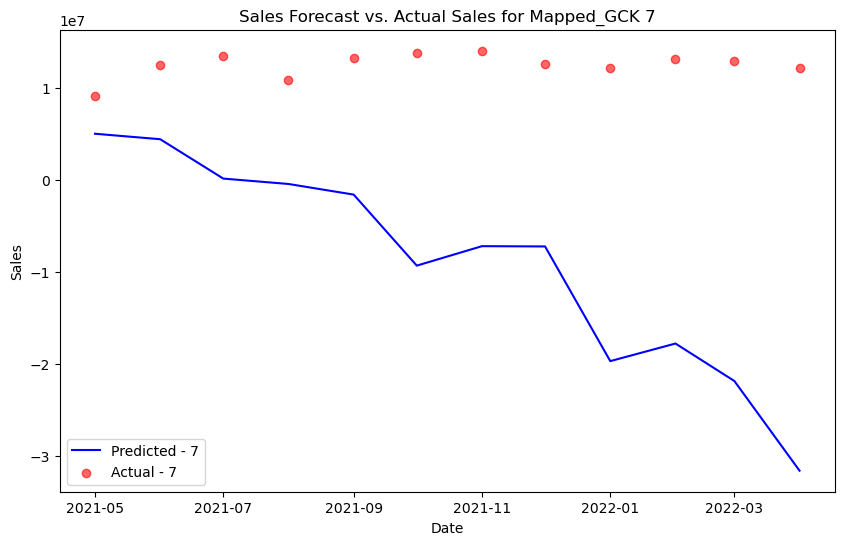

23:42:47 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 8


23:42:47 - cmdstanpy - INFO - Chain [1] done processing


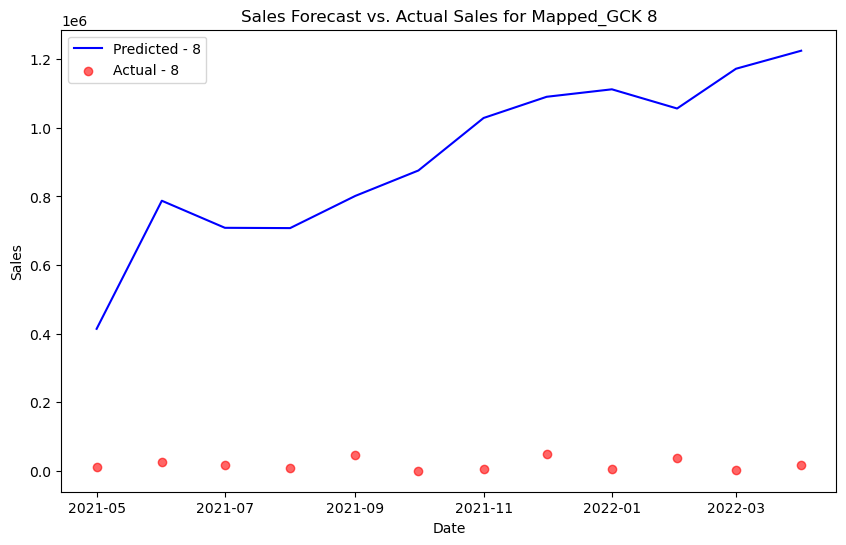

23:42:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 9


23:42:48 - cmdstanpy - INFO - Chain [1] done processing


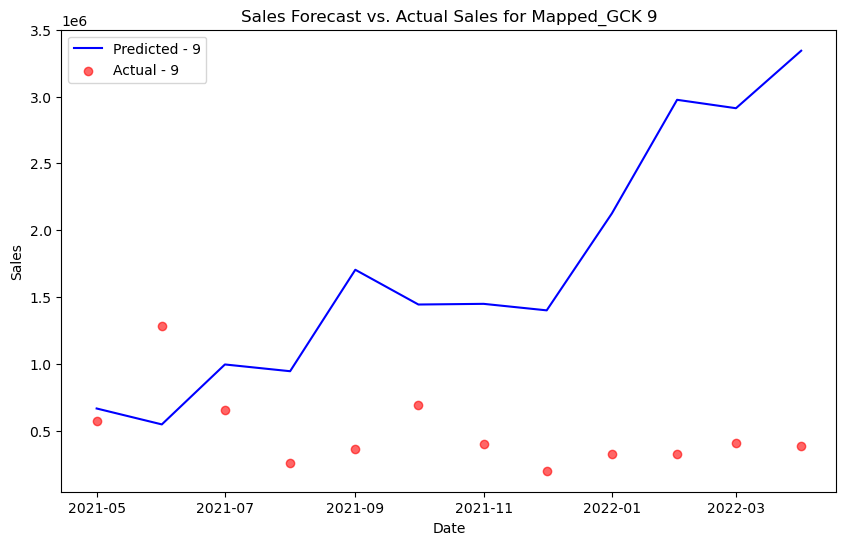

23:42:48 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 10


23:42:49 - cmdstanpy - INFO - Chain [1] done processing


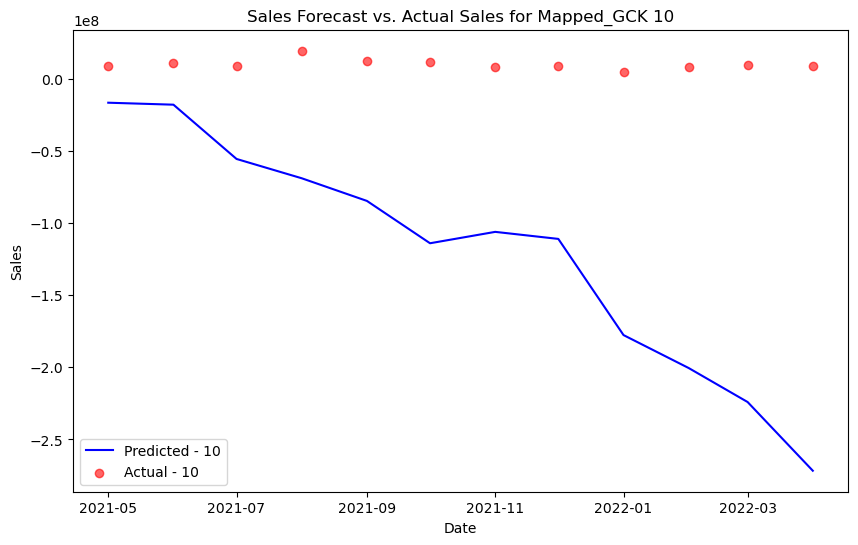

23:42:49 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 11


23:42:49 - cmdstanpy - INFO - Chain [1] done processing


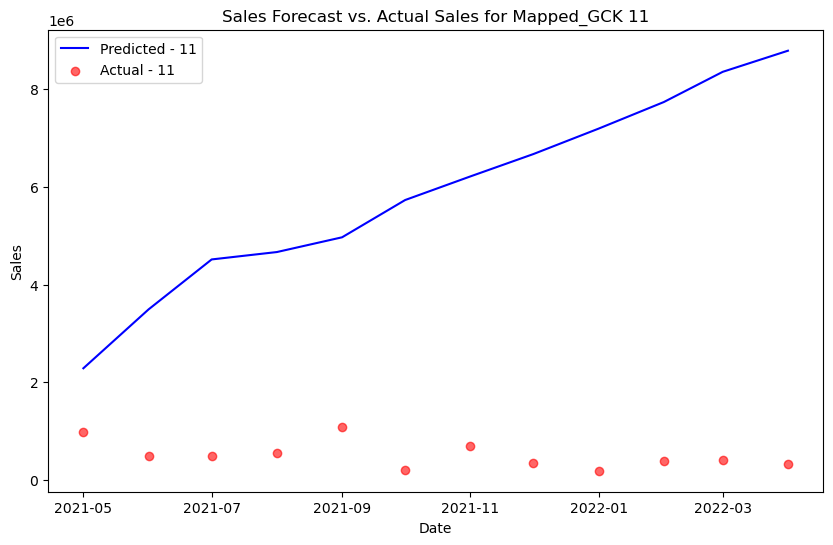

23:42:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 12


23:42:50 - cmdstanpy - INFO - Chain [1] done processing


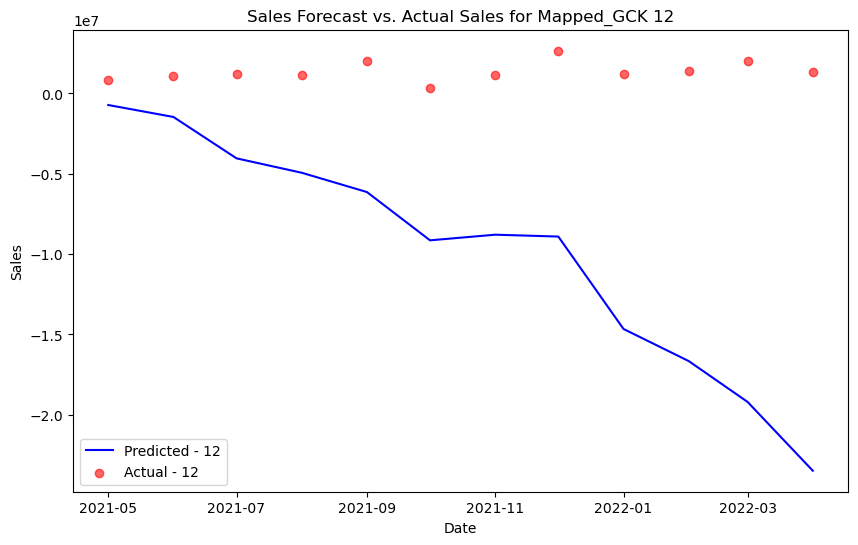

23:42:50 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 13


23:42:51 - cmdstanpy - INFO - Chain [1] done processing


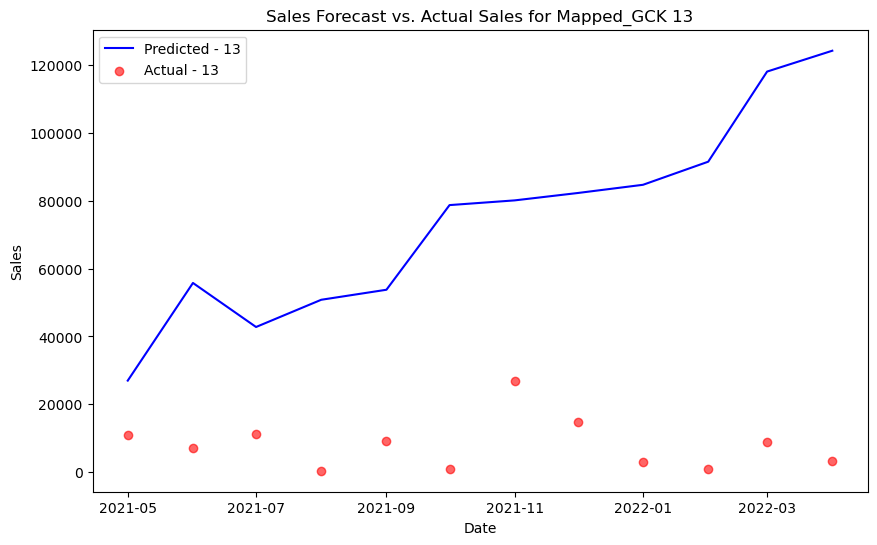

In [ ]:
model_name = "Prophet_with_features"

forecasts = {}

# Loop over each unique Mapped_GCK
for product in X_train['Mapped_GCK'].unique():
    print(f"Training model for Mapped_GCK: {product}")

    # Filter data for the current Mapped_GCK
    train_data = X_train[X_train['Mapped_GCK'] == product]
    test_data = X_test[X_test['Mapped_GCK'] == product]

    # Initialize Prophet model
    model = Prophet()
    
    # Add each feature as a regressor
    for feature in features_model:
        model.add_regressor(feature)

    # Fit the model on training data
    model.fit(train_data)

    # Create future dataframe using test data
    future = test_data[['ds']].copy()
    for feature in features_model:
        future[feature] = test_data[feature].values  # Ensure alignment

    # Predict sales
    forecast = model.predict(future)
    forecasts[product] = forecast  # Store results

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(test_data['y'], forecast['yhat']))

    # Store RMSE in dictionary
    if product not in rmse_results:
        rmse_results[product] = {}  # Create entry if not exists
    rmse_results[product][model_name] = rmse  # Store RMSE for this model

    # Create a new figure for each product
    plt.figure(figsize=(10, 6))
    
    # Plot forecasted sales (yhat)
    plt.plot(forecast['ds'], forecast['yhat'], label=f'Predicted - {product}', color='blue')

    # Plot actual sales (from test data)
    plt.scatter(test_data['ds'], test_data['y'], alpha=0.6, marker='o', label=f'Actual - {product}', color='red')

    # Finalize the plot
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Sales Forecast vs. Actual Sales for Mapped_GCK {product}')
    plt.legend()
    plt.show()

# Convert dictionary to DataFrame
rmse_df = pd.DataFrame.from_dict(rmse_results, orient='index')



In [ ]:
# Finalize the global plot
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Global Sales Forecast for All Products')
plt.legend()  # Show product labels
plt.show()

In [ ]:
rmse_results

{0: {'Prophet_with_features': 413410139.222335},
 1: {'Prophet_with_features': 40165402.14327928},
 2: {'Prophet_with_features': 457742.7243339424},
 3: {'Prophet_with_features': 324031.2864719902},
 4: {'Prophet_with_features': 151753.89237921717},
 5: {'Prophet_with_features': 67563179.77277131},
 6: {'Prophet_with_features': 138135.09849933922},
 7: {'Prophet_with_features': 24241438.21227267},
 8: {'Prophet_with_features': 924899.2884881039},
 9: {'Prophet_with_features': 1615868.1893829403},
 10: {'Prophet_with_features': 151619569.93639594},
 11: {'Prophet_with_features': 5756942.214187699},
 12: {'Prophet_with_features': 13244845.839154087},
 13: {'Prophet_with_features': 72440.33280302864}}

In [ ]:
X_train.MAB_ELE_PRO276.isna().sum()

0

In [ ]:
X_train.tail(50)

,MAB_ELE_PRO276,PRI27276_org,PRO271000_org,WKLWEUR840_org,MAB_ELE_PRO156,PRI27840_org,Mapped_GCK,date,Sales_EUR,ds,y
431,127,109,128,1,221,111,10,2018-11-01,8567995,2018-11-01,8567995
432,121,109,117,1,242,111,10,2018-12-01,6947507,2018-12-01,6947507
433,105,110,112,1,176,111,10,2019-01-01,8285718,2019-01-01,8285718
434,110,110,113,1,176,112,10,2019-02-01,4186503,2019-02-01,4186503
435,123,110,131,1,262,112,10,2019-03-01,11914314,2019-03-01,11914314
436,111,110,119,1,220,111,10,2019-04-01,6176321,2019-04-01,6176321
437,116,110,123,1,234,112,10,2019-05-01,11467047,2019-05-01,11467047
438,109,110,125,1,261,111,10,2019-06-01,13681879,2019-06-01,13681879
439,117,110,126,1,217,111,10,2019-07-01,10773805,2019-07-01,10773805
440,104,110,117,1,208,111,10,2019-08-01,7645745,2019-08-01,7645745


In [ ]:
df_model